<a href="https://colab.research.google.com/github/chaitanyajerripothula/shipment_delivery/blob/main/Shipment_Delivery_On_Time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [847]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [848]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

chaitu2283eb_shipment_delivery_path = kagglehub.dataset_download('chaitu2283eb/shipment-delivery')

print('Data source import complete.')


Data source import complete.


In [849]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import kagglehub
import warnings
warnings.filterwarnings("ignore")
import os
from scipy.stats import chi2_contingency
from sklearn.feature_selection import SelectKBest,chi2, RFE

#load_dataset
shipment_delivery_path = kagglehub.dataset_download('chaitu2283eb/shipment-delivery')
df = pd.read_csv(os.path.join(shipment_delivery_path, 'product_shipment_delivery.csv'))

In [850]:
'''Data Exploration (EDA)'''

def summary_stats(df):
    df.describe()
    df.info()
    df.head(5)
    df.isna().sum()

summary_stats(df)




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10999 non-null  int64  
 1   Warehouse_block      10999 non-null  object 
 2   Mode_of_Shipment     10999 non-null  object 
 3   Customer_care_calls  10999 non-null  int64  
 4   Customer_rating      10999 non-null  int64  
 5   Cost_of_the_Product  10901 non-null  float64
 6   Prior_purchases      10999 non-null  int64  
 7   Product_importance   10845 non-null  object 
 8   Gender               10999 non-null  object 
 9   Discount_offered     10999 non-null  int64  
 10  Weight_in_gms        10860 non-null  float64
 11  Reached.on.Time_Y.N  10999 non-null  int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 1.0+ MB


In [851]:
df.columns
df.columns = df.columns.str.lower()
df.rename(columns={'reached.on.time_y.n': 'on_time'}, inplace = True)

numerical_columns = ['customer_care_calls','customer_rating', 'cost_of_the_product', 'prior_purchases', 'discount_offered', 'weight_in_gms']
categorical_columns = ['warehouse_block', 'mode_of_shipment', 'product_importance', 'gender']

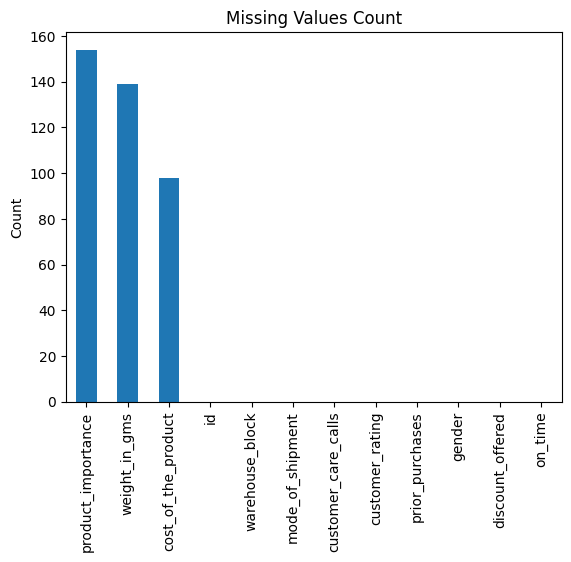

In [852]:
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

#Missing Values

df.isnull().sum().sort_values(ascending=False).plot(kind='bar', title='Missing Values Count')
plt.ylabel("Count")
plt.show()

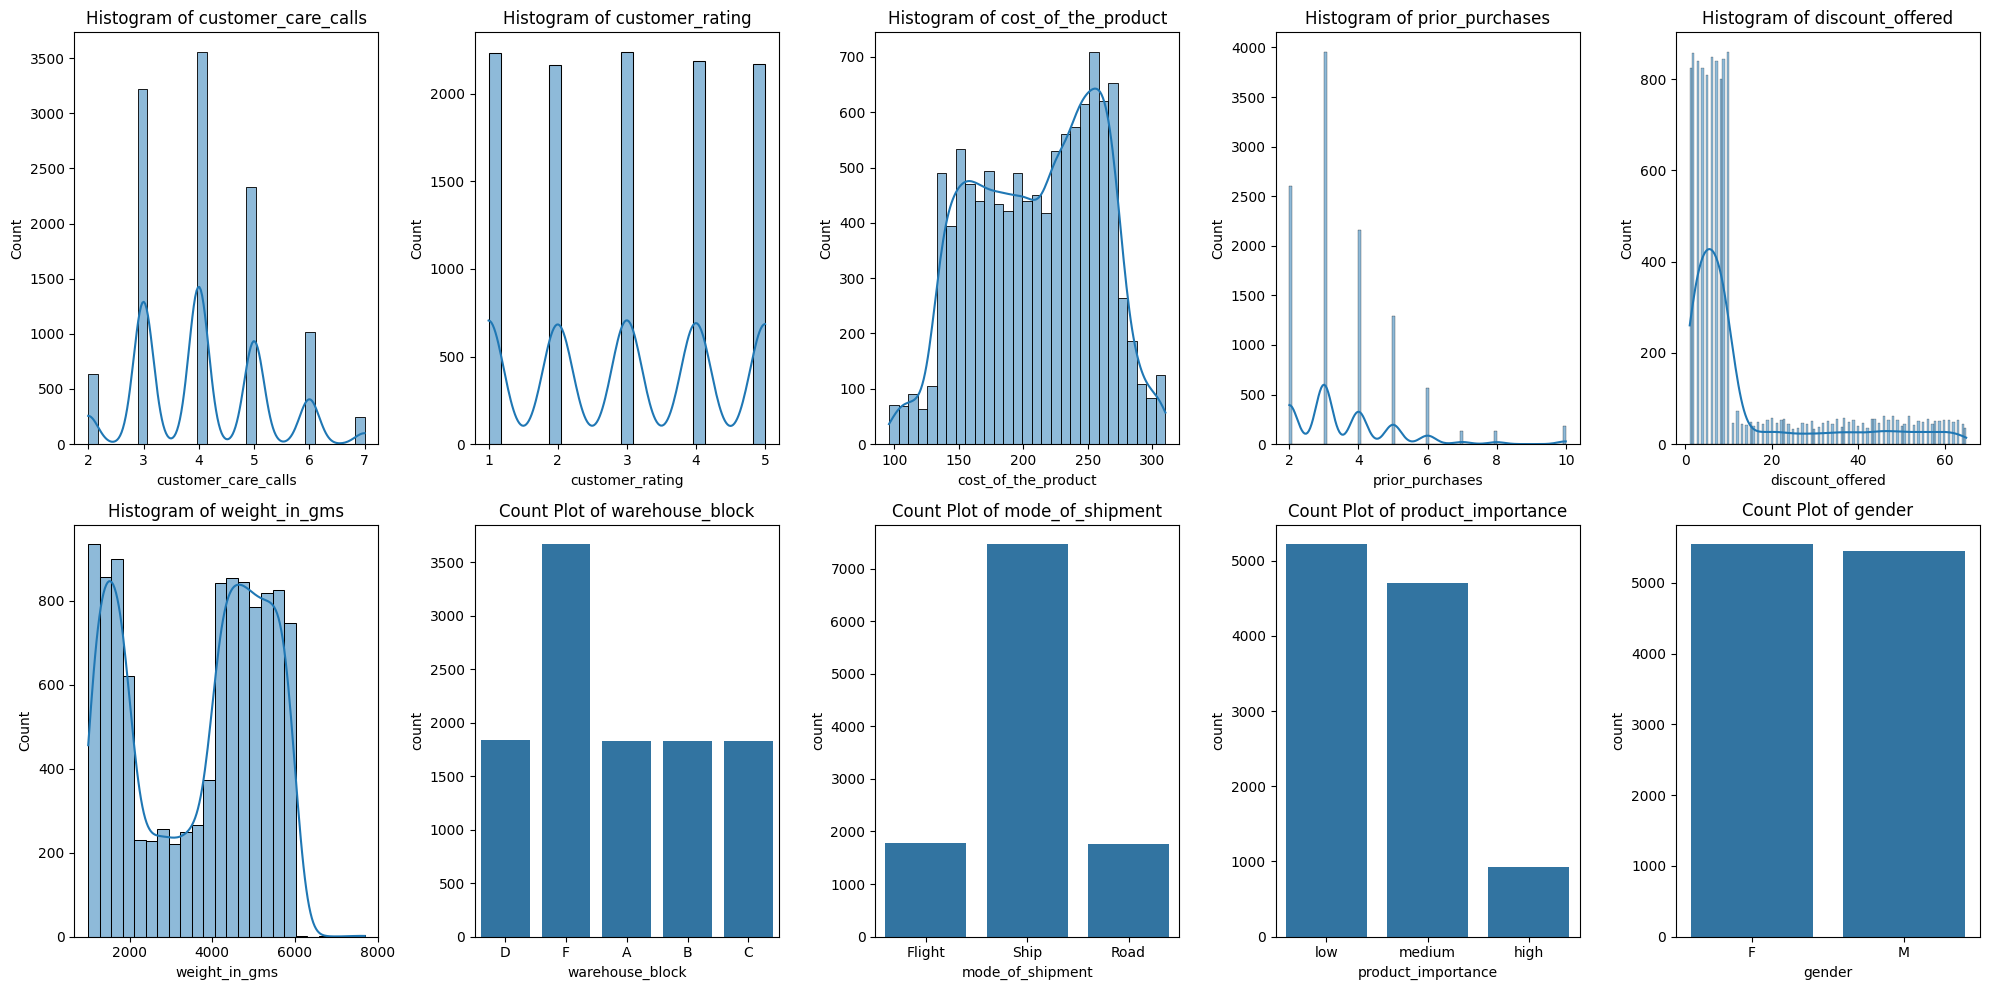

In [853]:
import math

# Calculate grid size dynamically
n_plots = len(numerical_columns + categorical_columns)
n_cols = 5  # Number of columns in the grid
n_rows = math.ceil(n_plots / n_cols)  # Calculate rows dynamically

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()

for i, column in enumerate(numerical_columns + categorical_columns):
    if df[column].dtype in ['int64', 'float64']:  # For numerical columns
        sns.histplot(df[column], kde=True, ax=axes[i])
        axes[i].set_title(f'Histogram of {column}')
    else:  # For categorical columns
        sns.countplot(x=column, data=df, ax=axes[i])
        axes[i].set_title(f'Count Plot of {column}')

# Turn off unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()

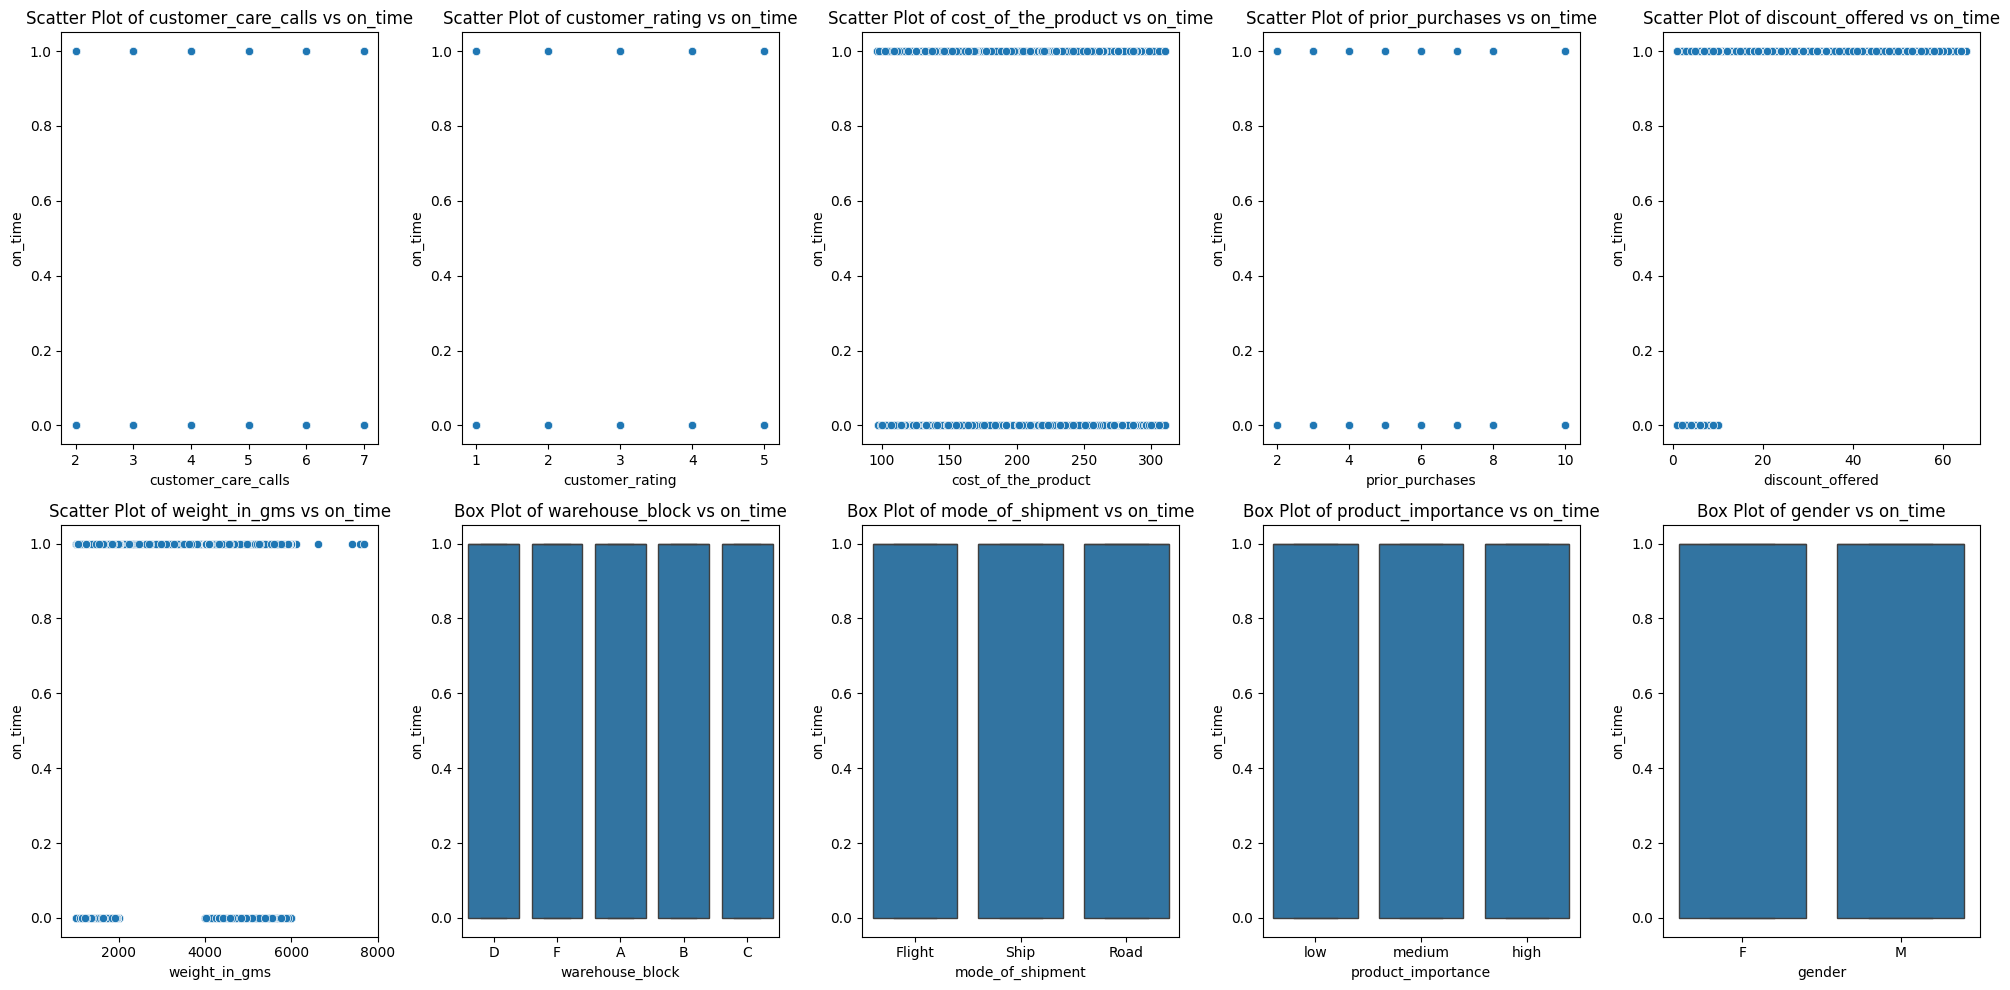

In [854]:
# Bivariate Analysis

# Calculate grid size dynamically
n_plots = len(numerical_columns + categorical_columns)
n_cols = 5  # Number of columns in the grid
n_rows = math.ceil(n_plots / n_cols)  # Calculate rows dynamically

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()

for i, column in enumerate(numerical_columns + categorical_columns):
    if df[column].dtype in ['int64', 'float64']:  ## Scatter Plot for Numerical Columns
        sns.scatterplot(x=column, y='on_time', data=df, ax=axes[i])
        axes[i].set_title(f"Scatter Plot of {column} vs on_time")
    else: ## Box Plot for Categorical vs Numerical
        sns.boxplot(x=column, y='on_time', data=df, ax=axes[i])
        axes[i].set_title(f"Box Plot of {column} vs on_time")

# Turn off unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()

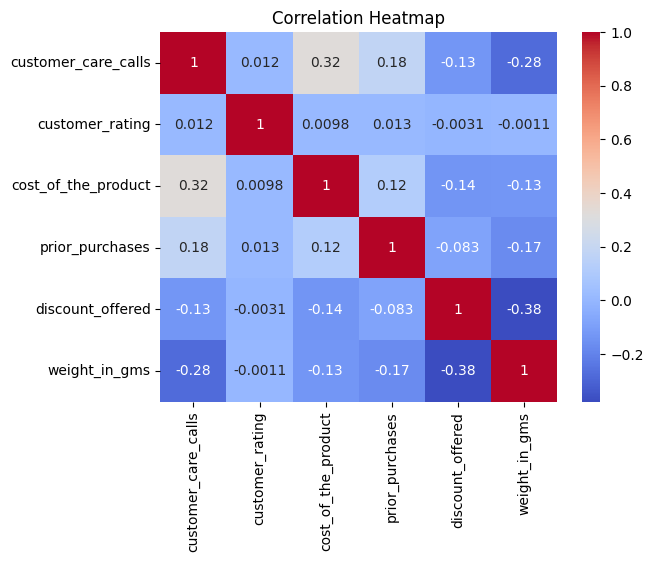

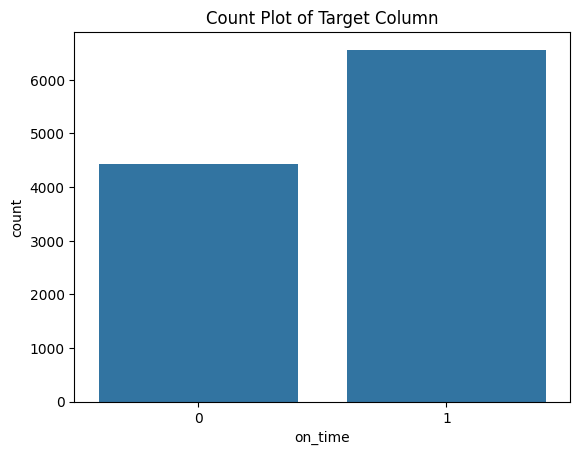

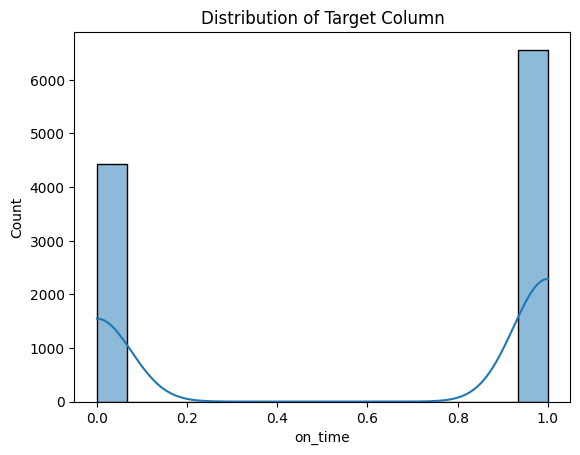

In [855]:
# Multivariate Analysis
## Correlation Heatmap
sns.heatmap(df[numerical_columns].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [856]:
from sklearn.impute import SimpleImputer

# Impute missing values using SimpleImputer
imputer = SimpleImputer(strategy='median')  # For numerical columns
df[numerical_columns] = imputer.fit_transform(df[numerical_columns])

# Impute categorical columns using 'most_frequent'
imputer_cat = SimpleImputer(strategy='most_frequent')
df[categorical_columns] = imputer_cat.fit_transform(df[categorical_columns])


In [857]:
skewness = df[numerical_columns].skew()
skewness[abs(skewness[numerical_columns]) > 0.5]

,0
prior_purchases,1.681897
discount_offered,1.798929


In [858]:
from sklearn.preprocessing import QuantileTransformer

transformer = QuantileTransformer(output_distribution='normal')
df[['prior_purchases', 'discount_offered']] = transformer.fit_transform(df[['prior_purchases', 'discount_offered']])
skewness = df[numerical_columns].skew()
skewness

,0
customer_care_calls,0.391926
customer_rating,0.004360
cost_of_the_product,-0.162943
prior_purchases,-0.781635
discount_offered,-1.673130
weight_in_gms,-0.271227


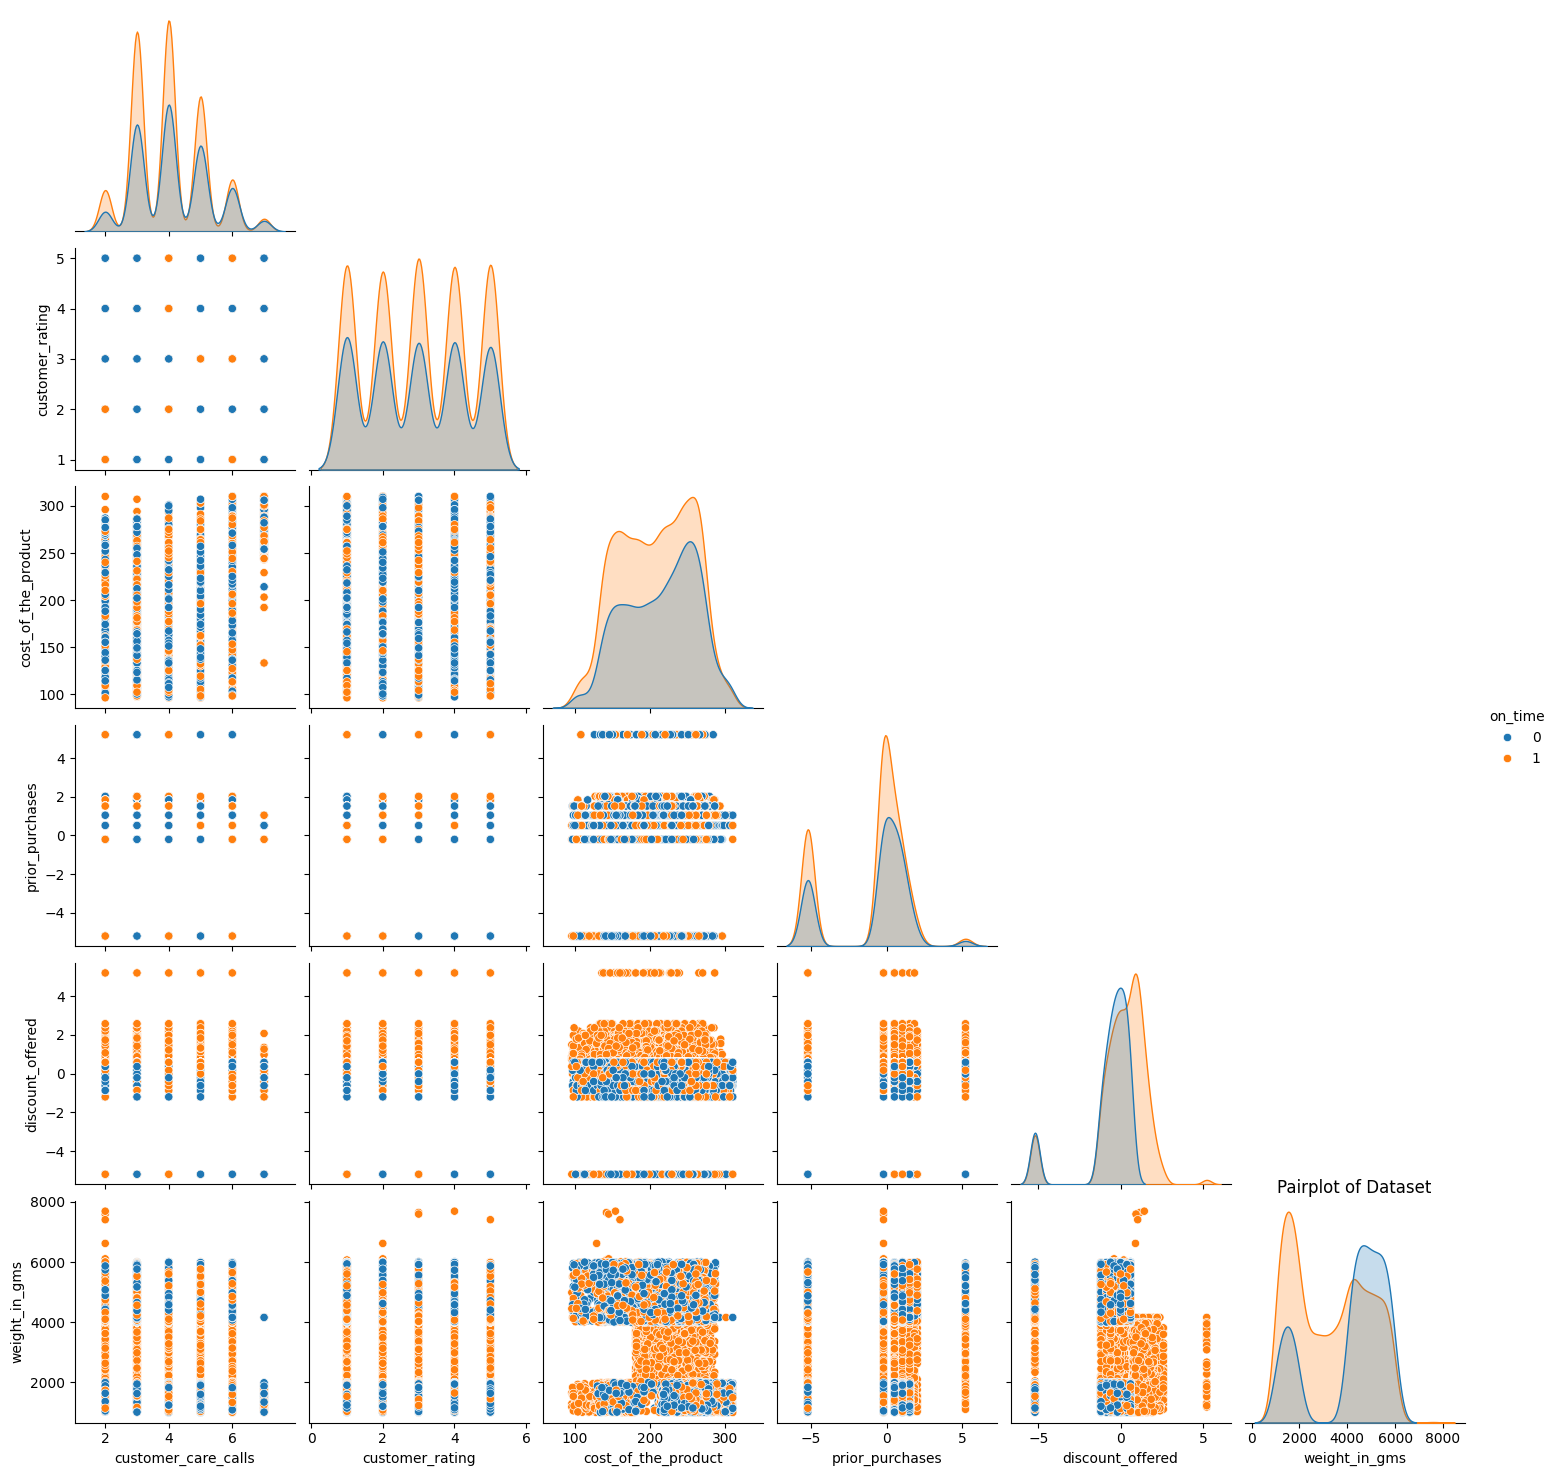

In [859]:
## Pairplot
sns.pairplot(df[numerical_columns + ['on_time']], dropna=True, hue="on_time", corner=True)
plt.title("Pairplot of Dataset")
plt.show()


In [860]:
def plot_graph(data_frame, columns_names, type):
    plt.figure(figsize=(30, 10))
    for i in range(0,len(columns_names)):
        plt.subplot(1, len(columns_names), i+1)
        if(type == 'boxplot'):
            sns.boxplot(y = data_frame[columns_names[i]], color = 'xkcd:blue', orient='v')
            plt.tick_params(axis='y', labelcolor='xkcd:blue')
        if(type == 'distplot'):
            sns.histplot(data_frame[columns_names[i]], color = 'xkcd:blue', kde=True, stat="density")
            plt.tick_params(axis='y', labelcolor='xkcd:blue', color = 'xkcd:blue')
        plt.tight_layout()

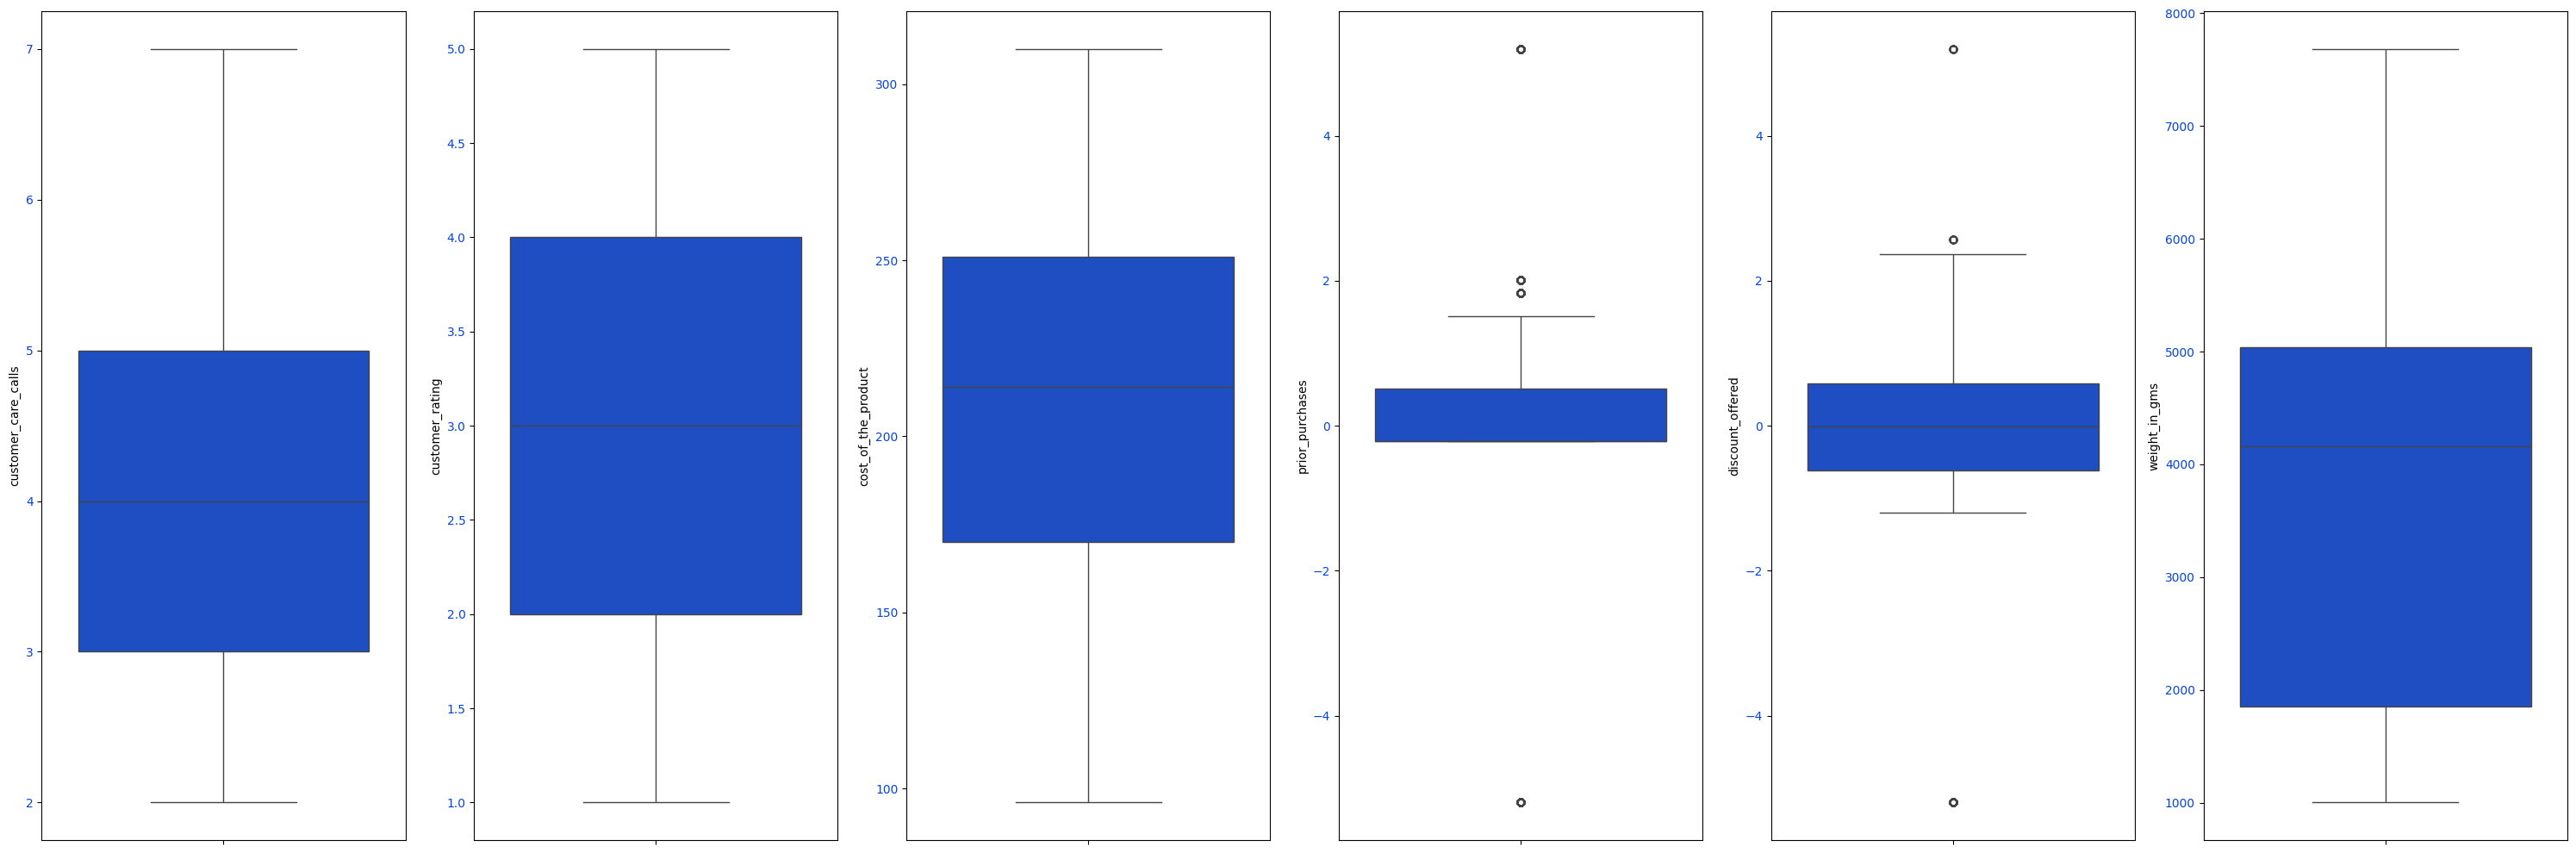

In [861]:

plot_graph(df, numerical_columns, 'boxplot')

In [862]:
for column in ['prior_purchases', 'discount_offered']:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3-Q1
    lower_threshold = Q1 - (IQR * 1.5)
    upper_threshold = Q3 + (IQR * 1.5)
    df[column] = np.where(df[column] >= upper_threshold, upper_threshold, df[column])
    df[column] = np.where(df[column] <= lower_threshold, lower_threshold, df[column])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   10999 non-null  int64  
 1   warehouse_block      10999 non-null  object 
 2   mode_of_shipment     10999 non-null  object 
 3   customer_care_calls  10999 non-null  float64
 4   customer_rating      10999 non-null  float64
 5   cost_of_the_product  10999 non-null  float64
 6   prior_purchases      10999 non-null  float64
 7   product_importance   10999 non-null  object 
 8   gender               10999 non-null  object 
 9   discount_offered     10999 non-null  float64
 10  weight_in_gms        10999 non-null  float64
 11  on_time              10999 non-null  int64  
dtypes: float64(6), int64(2), object(4)
memory usage: 1.0+ MB


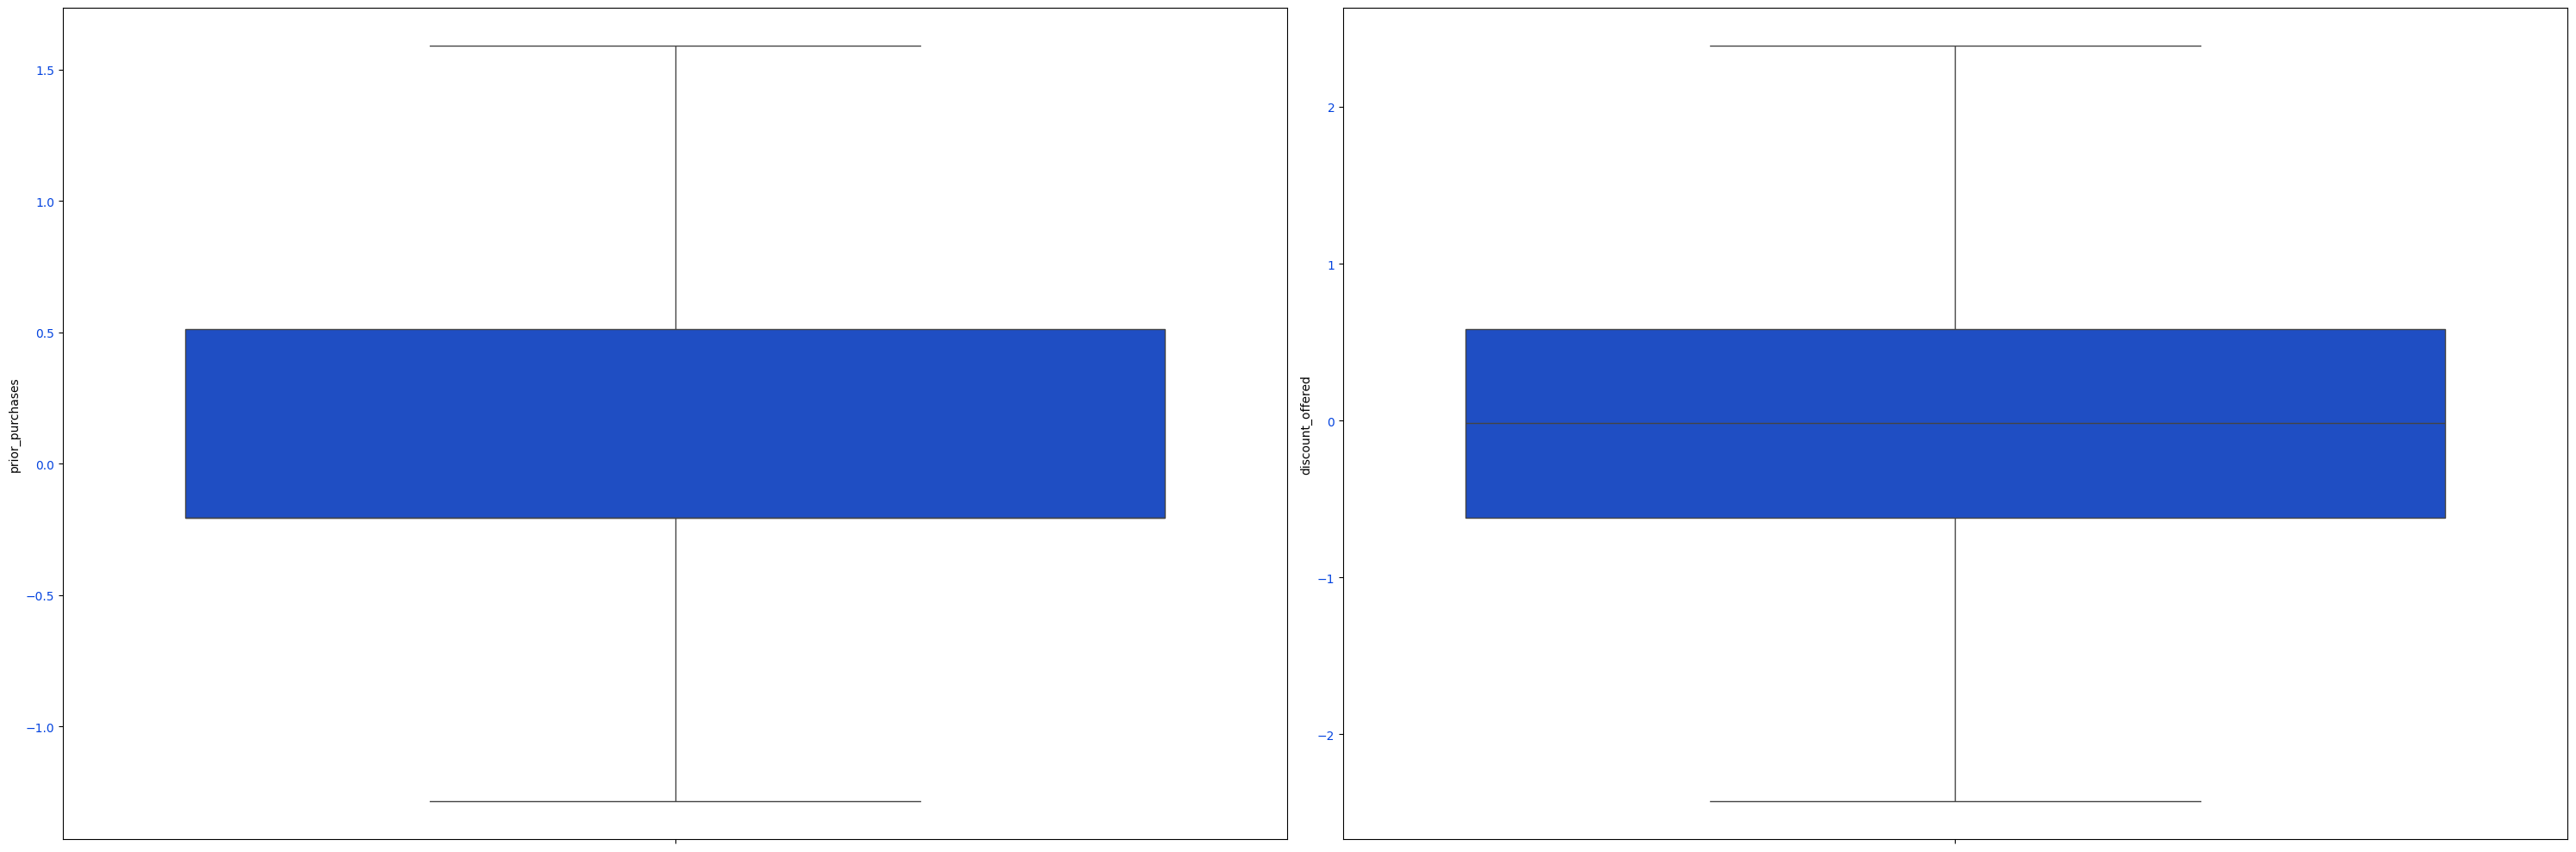

In [863]:
plot_graph(df, ['prior_purchases', 'discount_offered'], 'boxplot')
df.info()

In [864]:
df = pd.get_dummies(df, drop_first=False)
df.head(10)

df['product_importance_high_flight'] = df['product_importance_high'] * df['mode_of_shipment_Flight'] * df['cost_of_the_product']
df['product_importance_high_road'] = df['product_importance_high'] * df['mode_of_shipment_Road'] * df['cost_of_the_product']
df['product_importance_high_ship'] = df['product_importance_high'] * df['mode_of_shipment_Ship'] * df['cost_of_the_product']

df['product_importance_low_flight'] = df['product_importance_low'] * df['mode_of_shipment_Flight'] * df['cost_of_the_product']
df['product_importance_low_road'] = df['product_importance_low'] * df['mode_of_shipment_Road'] * df['cost_of_the_product']
df['product_importance_low_ship'] = df['product_importance_low'] * df['mode_of_shipment_Ship'] * df['cost_of_the_product']

df['product_importance_medium_flight'] = df['product_importance_medium'] * df['mode_of_shipment_Flight'] * df['cost_of_the_product']
df['product_importance_medium_road'] = df['product_importance_medium'] * df['mode_of_shipment_Road'] * df['cost_of_the_product']
df['product_importance_medium_ship'] = df['product_importance_medium'] * df['mode_of_shipment_Ship'] * df['cost_of_the_product']

df = df.drop(columns = ['mode_of_shipment_Flight', 'mode_of_shipment_Road', 'mode_of_shipment_Ship', 'product_importance_high', 'product_importance_low', 'product_importance_medium'], axis = 1)
df.head(5)

,id,customer_care_calls,customer_rating,cost_of_the_product,prior_purchases,discount_offered,weight_in_gms,on_time,warehouse_block_A,warehouse_block_B,...,gender_M,product_importance_high_flight,product_importance_high_road,product_importance_high_ship,product_importance_low_flight,product_importance_low_road,product_importance_low_ship,product_importance_medium_flight,product_importance_medium_road,product_importance_medium_ship
0,1,4.0,2.0,177.0,-0.207223,1.295363,1233.0,1,False,False,...,False,0.0,0.0,0.0,177.0,0.0,0.0,0.0,0.0,0.0
1,2,4.0,5.0,216.0,-1.286148,1.902873,3088.0,1,False,False,...,True,0.0,0.0,0.0,216.0,0.0,0.0,0.0,0.0,0.0
2,3,2.0,2.0,183.0,0.512061,1.421556,3374.0,1,True,False,...,True,0.0,0.0,0.0,183.0,0.0,0.0,0.0,0.0,0.0
3,4,3.0,3.0,176.0,0.512061,0.583496,1177.0,1,False,True,...,True,0.0,0.0,0.0,0.0,0.0,0.0,176.0,0.0,0.0
4,5,2.0,2.0,184.0,-0.207223,1.352623,2484.0,1,False,False,...,False,0.0,0.0,0.0,0.0,0.0,0.0,184.0,0.0,0.0


In [865]:
y = df['on_time']
X = df.drop(columns = ['on_time', 'id'], axis = 1)
X.head(5)

,customer_care_calls,customer_rating,cost_of_the_product,prior_purchases,discount_offered,weight_in_gms,warehouse_block_A,warehouse_block_B,warehouse_block_C,warehouse_block_D,...,gender_M,product_importance_high_flight,product_importance_high_road,product_importance_high_ship,product_importance_low_flight,product_importance_low_road,product_importance_low_ship,product_importance_medium_flight,product_importance_medium_road,product_importance_medium_ship
0,4.0,2.0,177.0,-0.207223,1.295363,1233.0,False,False,False,True,...,False,0.0,0.0,0.0,177.0,0.0,0.0,0.0,0.0,0.0
1,4.0,5.0,216.0,-1.286148,1.902873,3088.0,False,False,False,False,...,True,0.0,0.0,0.0,216.0,0.0,0.0,0.0,0.0,0.0
2,2.0,2.0,183.0,0.512061,1.421556,3374.0,True,False,False,False,...,True,0.0,0.0,0.0,183.0,0.0,0.0,0.0,0.0,0.0
3,3.0,3.0,176.0,0.512061,0.583496,1177.0,False,True,False,False,...,True,0.0,0.0,0.0,0.0,0.0,0.0,176.0,0.0,0.0
4,2.0,2.0,184.0,-0.207223,1.352623,2484.0,False,False,True,False,...,False,0.0,0.0,0.0,0.0,0.0,0.0,184.0,0.0,0.0


In [866]:
for col in X.columns:
  if X[col].min() < 0:
      X[col] = X[col] + abs(X[col].min())

selector = SelectKBest(chi2, k=12)
X_new = selector.fit_transform(X, y)

# Checking which features are selected
selected_features = X.columns[selector.get_support()]
print("Selected Features:", selected_features)

Selected Features: Index(['customer_care_calls', 'cost_of_the_product', 'prior_purchases',
       'discount_offered', 'weight_in_gms', 'product_importance_high_road',
       'product_importance_high_ship', 'product_importance_low_flight',
       'product_importance_low_road', 'product_importance_low_ship',
       'product_importance_medium_road', 'product_importance_medium_ship'],
      dtype='object')


In [867]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.21, random_state=42)


In [868]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Train a Random Forest Classifier
model = LogisticRegression(random_state=42, penalty='elasticnet', solver='saga', l1_ratio=0.36)
model.fit(X_train, y_train)
print(f"Logistic Regression Accuracy: {model.score(X_test, y_test)}")

Logistic Regression Accuracy: 0.6497835497835498


Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.38      0.47       947
           1       0.66      0.84      0.74      1363

    accuracy                           0.65      2310
   macro avg       0.64      0.61      0.60      2310
weighted avg       0.64      0.65      0.63      2310

Accuracy Score: 0.6497835497835498
AUC: 0.6086359132325814


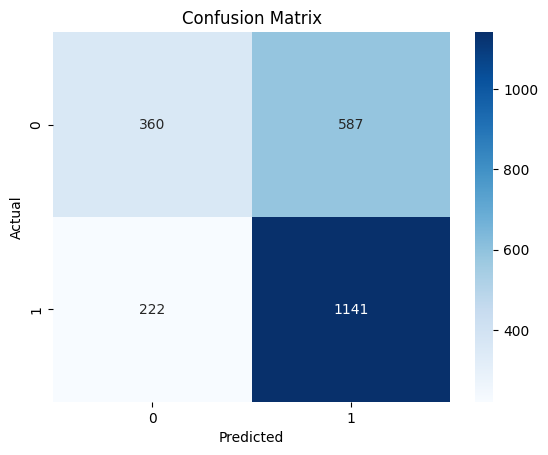

In [869]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Make predictions
y_pred = model.predict(X_test)
auc = roc_auc_score(y_test, y_pred)

# Classification report and accuracy
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print(f"AUC: {auc}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': np.logspace(-3, 3, 7), 'penalty': ['l1', 'l2', 'elasticnet'],'l1_ratio': np.linspace(0, 1, 11)}
grid_search = GridSearchCV(LogisticRegression(random_state=42,solver='saga'), param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
grid_search.fit(X_train, y_train)
print("Best Hyperparameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_


In [ ]:
# Retrain with the best model
best_model.fit(X_train, y_train)

# Evaluate on test data
y_pred_best = best_model.predict(X_test)
auc = roc_auc_score(y_test, y_pred_best)

# Classification report and accuracy
print("Classification Report (Tuned Model):\n", classification_report(y_test, y_pred_best))
print("Accuracy Score (Tuned Model):", accuracy_score(y_test, y_pred_best))
print(f"AUC: {auc}")
